In [1]:
import os
import random
import shutil
from pathlib import Path

# Paths
SOURCE_DIR = 'test/rps'
TARGET_DIR = 'dataset_split'
SPLITS = {'train': 0.7, 'validation': 0.15, 'test': 0.15}
CLASSES = ['rock', 'paper', 'scissor']

# Ensure repeatability
random.seed(123)

# Create split directories
for split in SPLITS:
    for cls in CLASSES:
        Path(os.path.join(TARGET_DIR, split, cls)).mkdir(parents=True, exist_ok=True)

# Split data
for cls in CLASSES:
    source_path = os.path.join(SOURCE_DIR, cls)
    images = os.listdir(source_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * SPLITS['train'])
    n_val = int(n_total * SPLITS['validation'])

    split_data = {
        'train': images[:n_train],
        'validation': images[n_train:n_train + n_val],
        'test': images[n_train + n_val:]
    }

    for split, files in split_data.items():
        for f in files:
            src = os.path.join(source_path, f)
            dst = os.path.join(TARGET_DIR, split, cls, f)
            shutil.copy2(src, dst)

print("✅ Dataset successfully split and copied!")


✅ Dataset successfully split and copied!


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory('dataset_split/train', image_size=(128, 128), batch_size=8)
val_dataset = image_dataset_from_directory('dataset_split/validation', image_size=(128, 128), batch_size=8)
test_dataset = image_dataset_from_directory('dataset_split/test', image_size=(128, 128), batch_size=8)

Found 313 files belonging to 3 classes.
Found 113 files belonging to 3 classes.
Found 94 files belonging to 3 classes.


In [3]:
from tensorflow.keras import layers, models

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

model = models.Sequential([
    layers.InputLayer(input_shape=(128, 128, 3)),

    data_augmentation,              # Apply augmentation only during training
    layers.Rescaling(1./255),       # Normalize pixels

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.summary()


C:\Users\evisp\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

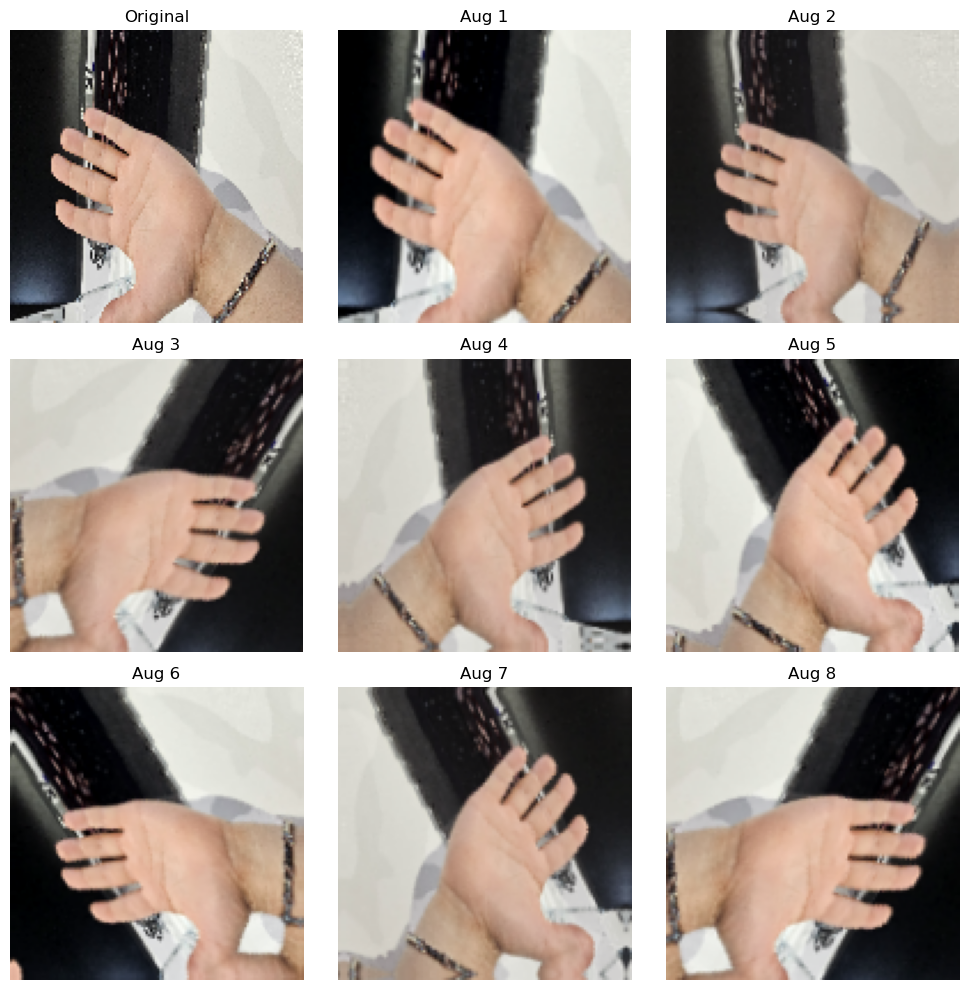

In [4]:
import matplotlib.pyplot as plt

# Get one image from the dataset
for images, labels in train_dataset.take(1):
    original_image = images[0]  # Pick the first image in the batch
    break  # Exit the loop

# Plot the original and 8 augmentations
plt.figure(figsize=(10, 10))

# Show original
plt.subplot(3, 3, 1)
plt.imshow(original_image.numpy().astype("uint8"))
plt.title("Original")
plt.axis("off")

# Show 8 augmented versions
for i in range(8):
    augmented_image = data_augmentation(tf.expand_dims(original_image, 0))[0]
    plt.subplot(3, 3, i + 2)
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(f"Aug {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,        # Stop if val_loss doesn't improve after 3 epochs
    restore_best_weights=True
)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=32,
    callbacks=[early_stop]
)



Epoch 1/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.3208 - loss: 1.3892 - val_accuracy: 0.4513 - val_loss: 1.0927
Epoch 2/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.3775 - loss: 1.0911 - val_accuracy: 0.5398 - val_loss: 0.9736
Epoch 3/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 392ms/step - accuracy: 0.4186 - loss: 1.0635 - val_accuracy: 0.4513 - val_loss: 1.0344
Epoch 4/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.4081 - loss: 1.0639 - val_accuracy: 0.5133 - val_loss: 1.0307
Epoch 5/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 440ms/step - accuracy: 0.4855 - loss: 0.9726 - val_accuracy: 0.5310 - val_loss: 1.0192
Epoch 6/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 327ms/step - accuracy: 0.5254 - loss: 0.9561 - val_accuracy: 0.5752 - val_loss: 0.9602
Epoch 7/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.5151 - loss: 0.9074 - val_accuracy: 0.6283 - val_loss: 0.8309
Epoch 8/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step - accuracy: 0.5473 - loss: 0.8491 - val_accu

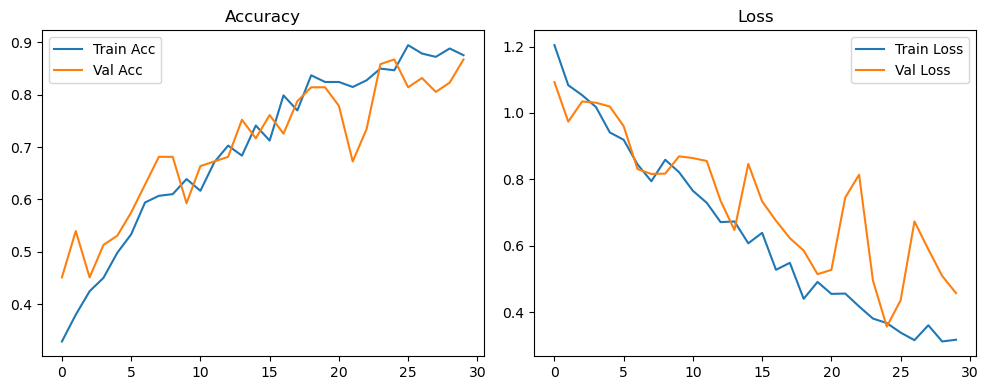

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8108 - loss: 0.5089
Test Loss: 0.6119
Test Accuracy: 0.8085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


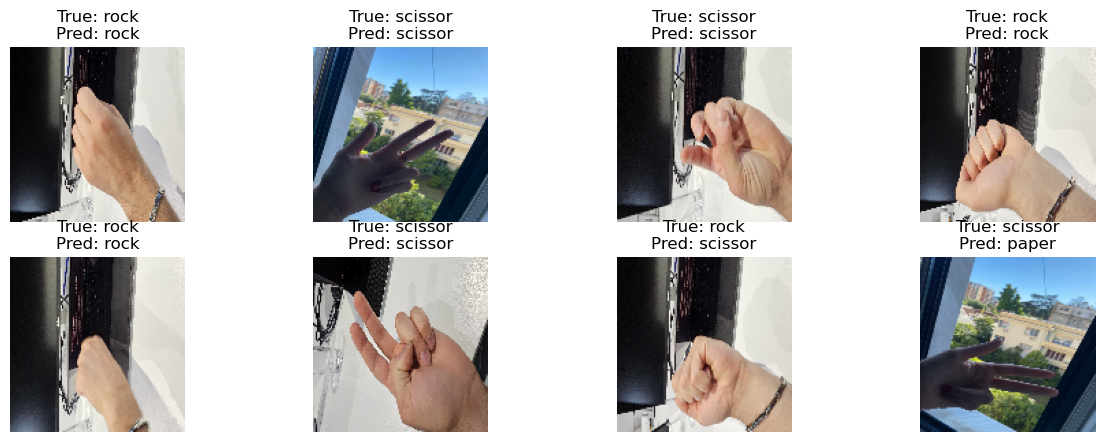

In [7]:
# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

import numpy as np

class_names = test_dataset.class_names 

for images, labels in test_dataset.take(1):  # take one batch from test set
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    
    plt.figure(figsize=(15, 5))
    for i in range(8):  # show first 8 images in batch
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds_classes[i]]}")
        plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


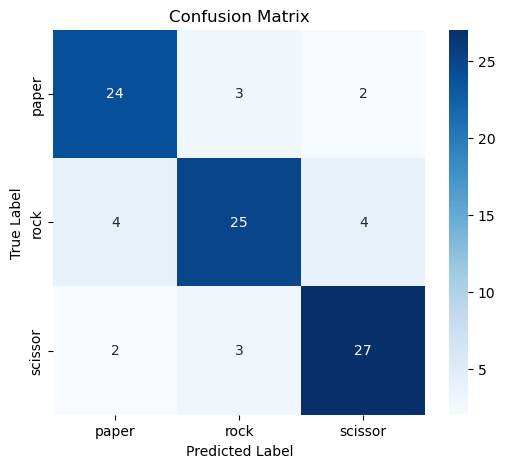

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predicted labels for the entire test set
true_labels = []
pred_labels = []

class_names = test_dataset.class_names

for images, labels in test_dataset:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    pred_labels.extend(preds_classes)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
